In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom
from sklearn.utils import resample
import keras
import dask
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Concatenate
from keras.applications.densenet import *
from numbers import Number
from keras.utils import to_categorical
import gc
import psutil
from cachetools import TTLCache
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle






# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


        
input_filepath = "../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/"
train_image_filepath = "../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train/"
# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


Automatically created module for IPython interactive environment

Filename.........: ../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train/ID_00019828f.dcm

Modality.........: CT
Image size.......: 512 x 512, 524288 bytes
Pixel spacing....: [0.488281, 0.488281]
Slice location...: (missing)


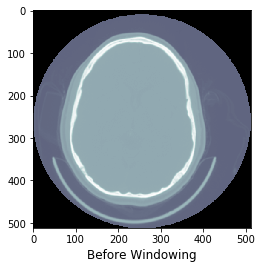

In [2]:
import matplotlib.pyplot as plt
import pydicom
from pydicom.data import get_testdata_files

print(__doc__)

filename = train_image_filepath + "ID_00019828f.dcm"
dataset = pydicom.dcmread(filename)

# Normal mode:
print()
print("Filename.........:", filename)
print()

print("Modality.........:", dataset.Modality)

if 'PixelData' in dataset:
    rows = int(dataset.Rows)
    cols = int(dataset.Columns)
    print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
        rows=rows, cols=cols, size=len(dataset.PixelData)))
    if 'PixelSpacing' in dataset:
        print("Pixel spacing....:", dataset.PixelSpacing)

# use .get() if not sure the item exists, and want a default value if missing
print("Slice location...:", dataset.get('SliceLocation', "(missing)"))

# plot the image using matplotlib
plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
plt.title('Before Windowing', y=-0.17)
plt.savefig('before-windowing.png')

plt.show()


In [3]:
dir(dataset)

['BitsAllocated',
 'BitsStored',
 'Columns',
 'HighBit',
 'ImageOrientationPatient',
 'ImagePositionPatient',
 'Modality',
 'PatientID',
 'PhotometricInterpretation',
 'PixelData',
 'PixelRepresentation',
 'PixelSpacing',
 'RescaleIntercept',
 'RescaleSlope',
 'Rows',
 'SOPInstanceUID',
 'SamplesPerPixel',
 'SeriesInstanceUID',
 'StudyID',
 'StudyInstanceUID',
 'WindowCenter',
 'WindowWidth',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_character_set',
 '_convert_pixel_data_using_handler',
 '_convert_pixel_data_without_handler',
 '_dataset_slice',
 '_do_pixel_data_conversion',
 '_pretty_str',
 '_sli

In [4]:
def brain_window(img):
    
    window_center =  img.WindowCenter if isinstance(img.WindowCenter, Number) else img.WindowCenter[0] 
    window_width = img.WindowWidth if isinstance(img.WindowWidth, Number) else img.WindowWidth[0] 
    slope, intercept  =  img.RescaleSlope, img.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = img.pixel_array
    img = img * dataset.RescaleSlope + intercept
    img[img < img_min] = img_min
    img[img > img_max] = img_max
    # Normalize
    img = (img - img_min) / (img_max - img_min)
    return img
    

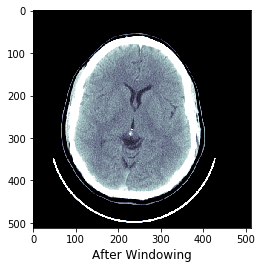

In [5]:
plt.imshow(brain_window(dataset), cmap=plt.cm.bone)
plt.title('After Windowing', y=-0.17)
plt.savefig('after-windowing.png')




In [6]:
def balanced_subsample(x,y,subsample_size=1.0):

    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = [a for a,b in zip(x,y) if b == yi ]
        class_xs.append((yi, elems))
        if min_elems == None or len(elems) < min_elems:
            min_elems = len(elems)

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems*subsample_size)

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            np.random.shuffle(this_xs)

        x_ = this_xs[:use_elems]
        y_ = np.empty(use_elems)
        y_.fill(ci)

        xs.extend(x_)
        ys.extend(y_)

    print (xs[:10], ys[:10])
    return xs,ys

In [7]:
#here we will sample the data for the first part of the classification task. Namely, we will try and identify whether there is a hemorrage or not. 
## first step would be to read a dcm file
filename = train_image_filepath + "ID_00019828f.dcm"
file_dcm = pydicom.dcmread(filename)
print(file_dcm.pixel_array.shape)
def get_two_class_labels(csv_file_path, stratify_percentage=1):
    """returns a list of tuples where the first value is the file id and the second is the label
    [('ID_00019828f', 0)]
    """
    
    input_dataframe = pd.read_csv(csv_file_path)
    filtered_input_dataframe = input_dataframe[input_dataframe['ID'].apply(lambda x : 'any' in x) ]
    files_with_ids = []
    X = list(filtered_input_dataframe['ID'])
    y = list(filtered_input_dataframe['Label'])
    num_samples = int(stratify_percentage * len(X))
    
    X,y = balanced_subsample(X,y,stratify_percentage)
    for k,v in list(zip(X, y)) :
        files_with_ids.append( ("_".join(k.split('_')[:2]), v))
        
    return files_with_ids

def get_images(image_folder_root, image_label_list):
    """returns a list of tuples with ('ID',label,file) where file is the ndarray (with a readable shape )"""
    file_dcm=[]
    X = []
    y = []
    for file_name,label in image_label_list:
        try:
            current_file = pydicom.dcmread(image_folder_root + file_name + '.dcm')
            pixel_array = current_file.pixel_array
            if (pixel_array.shape != (512,512)):
                continue
            file_dcm.append((file_name,label,brain_window(current_file)))
            y.append(label)
            X.append(pydicom.dcmread(image_folder_root + file_name + '.dcm').pixel_array)
        except ValueError:
            continue
    return X,y

(512, 512)


In [8]:
csv_file_path = "../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train.csv"
image_folder_root = train_image_filepath
files_with_ids = get_two_class_labels(csv_file_path,stratify_percentage=1)
X,y = [ x for x,y in files_with_ids], [y for x,y in files_with_ids]
print (len(files_with_ids))



['ID_ec2164713_any', 'ID_a690568ec_any', 'ID_2d181516f_any', 'ID_c2eb64ce1_any', 'ID_7a97499d0_any', 'ID_06888fe0c_any', 'ID_9887fd374_any', 'ID_99412c4f7_any', 'ID_5307ee749_any', 'ID_b730113c7_any'] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
215866


In [9]:
# This method down samples all positive training data into equal numbers of samples(i.e. min_count) in each category
"""
def down_sampler(csv_path):
    data = pd.read_csv(csv_path)
    epidural_count = (data['epidural']==1).sum() 
    intrapar_count = (data['intraparenchymal']==1).sum()
    intravent_count = (data['intraventricular']==1).sum()
    subarach_count = (data['subarachnoid']==1).sum()
    subdural_count = (data['subdural']==1).sum()
    
    min_count = min(epidural_count,intrapar_count,intravent_count,subarach_count,subdural_count)
    print("Sampling {} positives from each category...".format(min_count))
    
    epidural_samples = data[data['epidural']==1].sample(n=min_count)
    intrapar_samples = data[data['intraparenchymal']==1].sample(n=min_count)
    intraventricular_samples = data[data['intraventricular']==1].sample(n=min_count)
    subarachnoid_samples = data[data['subarachnoid']==1].sample(n=min_count)
    subdural_samples = data[data['subdural']==1].sample(n=min_count)
    
    # Concatenate all the above dataframes without duplicates 
    down_sampled_data = pd.concat([epidural_samples, intrapar_samples, 
                                   intraventricular_samples, subarachnoid_samples, subdural_samples]).drop_duplicates().reset_index(drop=True)
    print("The lenght of dataset with equal number of positives in each category is",len(down_sampled_data))
    return down_sampled_data
    


down_sampled= down_sampler("../input/hem-positive-data/hem_positive_train_set.csv")
down_sampled.to_csv("down_sampled_positive_data.csv")
    
"""  

'\ndef down_sampler(csv_path):\n    data = pd.read_csv(csv_path)\n    epidural_count = (data[\'epidural\']==1).sum() \n    intrapar_count = (data[\'intraparenchymal\']==1).sum()\n    intravent_count = (data[\'intraventricular\']==1).sum()\n    subarach_count = (data[\'subarachnoid\']==1).sum()\n    subdural_count = (data[\'subdural\']==1).sum()\n    \n    min_count = min(epidural_count,intrapar_count,intravent_count,subarach_count,subdural_count)\n    print("Sampling {} positives from each category...".format(min_count))\n    \n    epidural_samples = data[data[\'epidural\']==1].sample(n=min_count)\n    intrapar_samples = data[data[\'intraparenchymal\']==1].sample(n=min_count)\n    intraventricular_samples = data[data[\'intraventricular\']==1].sample(n=min_count)\n    subarachnoid_samples = data[data[\'subarachnoid\']==1].sample(n=min_count)\n    subdural_samples = data[data[\'subdural\']==1].sample(n=min_count)\n    \n    # Concatenate all the above dataframes without duplicates \n    

In [10]:
df1 = pd.DataFrame({'A':[1,2,3], 'B':[4,5,6]})
df2 = pd.DataFrame({'A':[1,6,10], 'B':[4,12,20]})
print(df1)
print(df2)
pd.concat([df1,df2]).drop_duplicates().reset_index(drop=True)

   A  B
0  1  4
1  2  5
2  3  6
    A   B
0   1   4
1   6  12
2  10  20


,A,B
0,1,4
1,2,5
2,3,6
3,6,12
4,10,20


In [11]:
class Model():
    
    
    def fit(self,X,y):
        raise NotImplemetedError()
    def predict(self, X):
        """Takes test data and returns the label probabilities """
        raise NotImplemetedError()

class Basic(Model):
    """intput dimension is the shape of the input"""
    def __init__(self, input_dimension, output_dimension):
        self.input_dimension = input_dimension
        self.output_dimension = output_dimension
        self.model = Sequential()
        self.model.add(Flatten())
        self.model.add(Dense(1000,input_shape=(512,512)))
        self.model.add(Activation('relu'))
        self.model.add(Dense(300))
        self.model.add(Activation('relu'))
        self.model.add(Dense(100))
        self.model.add(Activation('relu'))
        self.model.add(Dense(25))
        self.model.add(Activation('relu'))
        self.model.add(Dense(1))
        self.model.add(Activation('sigmoid'))
        self.model.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])

 
        
    
    def fit(self, X,y):
        self.model.fit(x=X,y=y,epochs=1,batch_size=8)
    def predict(self, X):
        self.model.predict(X)
    def save(self,filename):
        self.model.save(filename)


In [12]:
class Basic(Model):
    """intput dimension is the shape of the input"""
    def __init__(self, input_dimension, output_dimension):
        self.input_dimension = input_dimension
        self.output_dimension = output_dimension
        self.model = Sequential()
        self.model.add(Flatten())
        self.model.add(Dense(300,input_shape=(512,512)))
        self.model.add(Activation('relu'))
        self.model.add(Dense(50))
        self.model.add(Activation('relu'))
        self.model.add(Dense(25))
        self.model.add(Activation('relu'))
        self.model.add(Dense(10))
        self.model.add(Activation('relu'))
        self.model.add(Dense(2))
        self.model.add(Activation('softmax'))
        self.model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

 
        
    
    def fit(self, X,y):
        self.model.fit(x=X,y=to_categorical(y),epochs=1,batch_size=8)
    def predict(self, X):
        self.model.predict(X)

In [13]:
class DenseNetModel(Model):
    def __init__(self):
        self.input_tensor = Input((512,512,1))
        self.concatenate = Concatenate()([ self.input_tensor, self.input_tensor, self.input_tensor])
        self.densenet_model = DenseNet121(include_top=False, weights='imagenet',input_tensor=self.concatenate)
        self.model = Sequential()
        self.model.add(self.densenet_model)
        self.model.add(Flatten())
        self.model.add(Dense(100))
        self.model.add(Activation('relu'))
        self.model.add(Dense(1))
        self.model.add(Activation('sigmoid'))
        self.model.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])

        
        
        
    def fit(self, X,y):
        self.model.fit(x=X,y=y,epochs=1,batch_size=8)
    def predict(self, X):
        self.model.predict(X)

In [14]:
#Has an image loader for providing the image for a given id in the dataset 
#Written separately so that we can add any preprocessing steps here while the image is being loaded into memory
class DataLoader:
    def __init__(self,base_file_path, cache_size=500, ttl_seconds=20):
        self.base_file_path = base_file_path
        self.cache = TTLCache(maxsize=cache_size,ttl=ttl_seconds)
        
        
    ##will apply only brain windowing while loading the image for now. Need to change this to apply all windowing functions. 
    def load_image(self, image_id):
        if image_id in self.cache:
            return self.cache[image_id]
        
        else:
            current_file = pydicom.dcmread(image_folder_root + image_id + '.dcm')
            pixel_array = brain_window(current_file)
            self.cache[image_id] = pixel_array
            return pixel_array
    def trigger_expire(self):
        self.cache.expire()
            
            
                
        

In [15]:
class  ModelTrainer(object):
    
    def __init__(self, dataloader, training_batch_size=8, split_size = 400):
        
        self.dataloader = dataloader
        self.split_size = split_size
        
    
    """Takes X and y as the file name and labels and """    
    def fit(self, X,y,model, epochs=10, training_batch_size=8 ):
        splits = len(y) // self.split_size +1
        
        splitter = StratifiedKFold(n_splits=splits, random_state=None, shuffle=True)
        count = 1
        while epochs > 0:
            X,y = shuffle(X,y)
            print("Starting epoch ",count)
            ##TODO: add a better split and shuffle mechanism
            processed = 0
            while processed < len(y):
                batch_imgs = []
                batch_labels = []
            
                current_x = X[processed:min(processed+self.split_size,len(y))]
                current_y = y[processed:min(processed+self.split_size,len(y))]
                for img,label in zip(current_x,current_y):
                    image = self.dataloader.load_image(img)
                    ##Figure out how many images are getting ignored because of this assumption
                    ##check if all reshape operations can happen in the dataloader
                    if image.shape != (512,512):
                        continue
                    batch_imgs.append(image)
                    batch_labels.append(label)
                print("using  batch with size", len(batch_imgs), len(batch_labels), "Processed ", processed, "Total ", len(y))
                model.fit(np.array(batch_imgs),np.array(batch_labels))
                self.dataloader.trigger_expire()
                del batch_imgs
                del batch_labels
                
                gc.collect()
                processed +=self.split_size
            print("Ending Epoch", count)
            print("Saving Model")
            model.save("basic-model-1-epochs.h5")
            epochs-=1
            count+=1
        return model
        
    

In [16]:
dataloader = DataLoader(train_image_filepath)
model = Basic(5,5)
trainer = ModelTrainer(dataloader,split_size=1000)
model = trainer.fit(X,y,model)

Starting epoch  1
using  batch with size 1000 1000 Processed  0 Total  215866
Epoch 1/1
1000/1000 [==============================] - 110s 110ms/step - loss: 1.0004 - accuracy: 0.5890
using  batch with size 1000 1000 Processed  1000 Total  215866
Epoch 1/1
1000/1000 [==============================] - 109s 109ms/step - loss: 0.7061 - accuracy: 0.6340
using  batch with size 999 999 Processed  2000 Total  215866
Epoch 1/1
999/999 [==============================] - 109s 109ms/step - loss: 0.6324 - accuracy: 0.6677
using  batch with size 1000 1000 Processed  3000 Total  215866
Epoch 1/1
1000/1000 [==============================] - 110s 110ms/step - loss: 0.6844 - accuracy: 0.6580
using  batch with size 999 999 Processed  4000 Total  215866
Epoch 1/1
999/999 [==============================] - 110s 110ms/step - loss: 0.6930 - accuracy: 0.6156
using  batch with size 998 998 Processed  5000 Total  215866
Epoch 1/1
998/998 [==============================] - 109s 110ms/step - loss: 0.6085 - accura

AttributeError: 'Basic' object has no attribute 'save'

In [17]:
import pandas as pd
hem_positive_test_set = pd.read_csv("../input/hem_positive_test_set.csv")
hem_positive_train_set = pd.read_csv("../input/hem_positive_train_set.csv")

FileNotFoundError: [Errno 2] File b'../input/hem_positive_test_set.csv' does not exist: b'../input/hem_positive_test_set.csv'